In [3]:
from openpyxl import load_workbook
import re
import pandas as pd
import numpy as np

In [180]:
def extract_number(sheet, i):
    filename = sheet["C" + str(i)].value
    filename.replace(" ", "")
    number_of_dashes = filename.count("-")
    if number_of_dashes == 5 or number_of_dashes == 4:
        number = filename.split("-")[4]
    else:
        number = ""
    return number

In [181]:
def find_number(sheet):
    number_list = []
    for i in range(2, sheet.max_row):
        number = extract_number(sheet, i)
        if len(number) == 6:
            number_list.append(number)
    return number_list

In [182]:
workbook = load_workbook(filename="Lead Monitoring Report  (52).xlsx")
sheet = workbook.active
numbers_list = find_number(sheet)

In [183]:
def vectorize_words(df):
    n_grams = df["n-gram"].tolist()
    unique_n_grams = list(dict.fromkeys(n_grams))
    return unique_n_grams

In [184]:
def organize_words(df):
    words_per_file = dict()
    for i in range(1, 186):
        n_grams = df["n-gram"][df.filecount == i].tolist()
        frequencies = df["frequency"][df.filecount == i].tolist()
        filenames = df["filename"][df.filecount == i].tolist()
        number = filenames[0].split("-")[4][0:6]
        words_per_file[number] = [(n_grams[j], frequencies[j]) for j in range(len(n_grams))]
    return words_per_file

In [185]:
df = pd.read_csv("output.csv")
words_list = vectorize_words(df)
words_and_frequencies = organize_words(df)

In [186]:
common_files = list(set(numbers_list).intersection(words_and_frequencies.keys()))
words_dict = {}
for file_number in words_and_frequencies.keys():
    if file_number in common_files:
        words_dict[file_number] = words_and_frequencies[file_number]

In [344]:
def vectorize_names(sheet, column, numbers_list):
    big_name_list = []
    encodings_dict = dict()
    for i in range(2, sheet.max_row):
        names = sheet[column + str(i)].value
        names = names.replace(",", ", ")
        names = names.split("/")[1]
        x = re.findall("\d+", names)
        if (x):
            total = re.split('\d+', names)[1]
        else:
            continue
        total = total.replace(") ", "")
        name_list = total.split(", ")
        name_list = [name.lower() for name in name_list]
        name_list = [name.lstrip() for name in name_list]
        file_number = extract_number(sheet, i)
        if file_number in numbers_list:
            big_name_list += name_list
            encodings_dict[file_number] = name_list
        
    final_list = list(dict.fromkeys(big_name_list))
    final_list = sorted(final_list)
    return final_list[1:], encodings_dict

In [195]:
def hot_encode_numbers(lst, dct):
    for key in dct.keys():
        dct[key] = [1 if i in dct[key] else 0 for i in lst]

In [216]:
R_list, R_dict = vectorize_names(sheet, "Q", common_files)
LR_list, LR_dict = vectorize_names(sheet, "R", common_files)
OLR_list, OLR_dict = vectorize_names(sheet, "S", common_files)

hot_encode_numbers(R_list, R_dict)
hot_encode_numbers(LR_list, LR_dict)
hot_encode_numbers(OLR_list, OLR_dict)

102


In [333]:
R_dict

['abay veli̇',
 'adil gürkan ceyhan',
 'ahmet ergin efendi̇oğlu',
 'ahmet okan şeker',
 'akif bakan',
 'alan beere',
 'ali ayla',
 'ali murat gürkan',
 'ali volkan debbağ',
 'alireza moghaddam',
 'andrew johnson',
 'antidio magnani',
 'berke tarakçioğlu',
 'beyhan gören',
 'borahan cönkeroğlu',
 'brian humphreys',
 'brian rostron',
 'burak salantur',
 'can boğa',
 'ceren arslan',
 'chris sharratt',
 'coşan ayan',
 'craige thomas',
 'cumhur dervi̇şoğlu',
 'dara williams ',
 'dave robinson',
 'david grinter',
 'david scull',
 'douglas london',
 'eda teki̇roğlu',
 'ekin eki̇z',
 'eleanor cross',
 'elif yildirim',
 'emil maschner',
 'emir önal',
 'enver gümüş',
 'erkan i̇nce',
 'evren eki̇nci̇',
 'fatih kalyoncu',
 'frederic mckinnon',
 'guy thomas',
 'gyashvir jalabhay',
 'görkem taşcı',
 'hakan keskin',
 'harry cotton',
 'harun kirmaci',
 'ian dove',
 'james heduvan',
 'john hooper',
 'khalid gill',
 'kian chung beh',
 'köksal çiğ',
 'lee wright',
 'levent kiliç',
 'lirio gonzalez',
 'ma

In [330]:
count = 0
for i in R_dict.keys():
    count += R_dict[i][2]
print(count)

70


In [198]:
def hot_encode_words(words_list, words_per_file):
    encoding = dict()
    i=1
    for number in words_per_file.keys():
        for pair in words_per_file[number]:
            if number not in encoding.keys():
                encoding[number] = np.zeros(len(words_list))
            encoding[number][words_list.index(pair[0])] = pair[1]
        print(i)
        i+=1
    return encoding

In [205]:
print(R_dict['005687'])

102


In [220]:
words_encoding = hot_encode_words(words_list, words_dict)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


In [222]:
def match_encodings(numbers_encoding, words_encoding):
    X = []
    Y = []
    for n1 in numbers_encoding.keys():
        for n2 in words_encoding.keys():
            if n1 == n2:
                X.append(words_encoding[n2])
                Y.append(numbers_encoding[n1])
    return X, Y

In [223]:
X, Y = match_encodings(R_dict, words_encoding)

In [227]:
print(len(Y[0]))

102


In [228]:
import pickle
with open("data.pickle", 'wb') as f:
    pickle.dump([X, Y], f)

In [229]:
import pickle
from sklearn.model_selection import train_test_split
with open('data.pickle', 'rb') as f:
    X, Y = pickle.load(f)

df_X = pd.DataFrame(X)
dfY = pd.DataFrame(Y)

In [309]:
to_be_deleted = []
for i in range(dfY.shape[1]):
    count = 0
    for y in Y:
        count += y[i]
    if count < 10:
        to_be_deleted.append(i)
        
df_Y = dfY.drop(to_be_deleted, axis=1)
df_Y.columns = range(df_Y.shape[1])

In [310]:
names_list = pd.DataFrame(R_list)
names_list = names_list.drop(to_be_deleted).reset_index(drop=True)

In [323]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from random import sample
%matplotlib inline

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

no_of_people = df_Y.shape[1]
X_train, X_test = [[] for i in range(no_of_people)], [[] for i in range(no_of_people)]
Y_train, Y_test = [[] for i in range(no_of_people)], [[] for i in range(no_of_people)]
total = df_Y.shape[0]
test_portion = round(total * 0.3)
for i in range(no_of_people):
    k = 0
    for j in range(total):
        if df_Y.iloc[j][i] == 1 or total - j <= test_portion - k:
            Y_test[i].append(df_Y.iloc[j].tolist()[i])
            X_test[i].append(df_X.iloc[j])
            k += 1
        else:
            Y_train[i].append(df_Y.iloc[j])
            X_train[i].append(df_X.iloc[j])
        if k == 3:
            indices = np.arange(j + 1, df_Y.shape[0])
            test_indices = sample(list(indices), test_portion - 3)
            for z in range(j + 1, df_Y.shape[0]):
                if z in test_indices:
                    Y_test[i].append(df_Y.iloc[z].tolist()[i])
                    X_test[i].append(df_X.iloc[z])
                else:
                    Y_train[i].append(df_Y.iloc[z])
                    X_train[i].append(df_X.iloc[z])
            break

In [429]:
Y_pred = []
models = {}
for i in range(no_of_people):
    x_train = X_train[i]
    y_train = [y[i] for y in Y_train[i]]
    if sum(y_train) == 0:
        Y_pred.append(np.array([0 for y in range(26)]))
        print("noooo")
        continue
    models[i] = sgd.fit(x_train, y_train)
    y_pred = models[i].predict(X_test[i])
    print(y_pred)
    Y_pred.append(y_pred)

[0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0]
[1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0]
[0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0]
[0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
[1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0]
[1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0]
[0 0 1 1 1 1

In [374]:
X_test[i][0]

0         18.0
1          1.0
2         12.0
3          5.0
4         11.0
          ... 
395583     0.0
395584     0.0
395585     0.0
395586     0.0
395587     0.0
Name: 12, Length: 395588, dtype: float64

In [371]:
models

{0: Pipeline(steps=[('tfidf', TfidfTransformer()),
                 ('clf',
                  SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                                tol=None))]),
 1: Pipeline(steps=[('tfidf', TfidfTransformer()),
                 ('clf',
                  SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                                tol=None))]),
 2: Pipeline(steps=[('tfidf', TfidfTransformer()),
                 ('clf',
                  SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                                tol=None))]),
 3: Pipeline(steps=[('tfidf', TfidfTransformer()),
                 ('clf',
                  SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                                tol=None))]),
 4: Pipeline(steps=[('tfidf', TfidfTransformer()),
                 ('clf',
                  SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                                tol=None))]),
 5: Pipeline(steps=[

In [325]:
Y_pred_transposed = [*zip(*Y_pred)]
Y_test_transposed = [*zip(*Y_test)]

In [326]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
Y_pred_list = [p.tolist() for p in Y_pred]
print('accuracy %s' % accuracy_score(Y_pred_transposed, Y_test_transposed))
print(classification_report(Y_test_transposed, Y_pred_transposed))
precision, recall, fscore, support = precision_recall_fscore_support(Y_test_transposed, Y_pred_transposed)

accuracy 0.0
              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       1.00      1.00      1.00        25
           2       0.96      1.00      0.98        24
           3       0.71      0.71      0.71        14
           4       0.83      0.95      0.89        21
           5       1.00      0.53      0.69        19
           6       0.65      0.94      0.77        16
           7       0.83      0.42      0.56        12
           8       0.82      0.56      0.67        16
           9       0.67      0.40      0.50        10
          10       0.86      0.50      0.63        12
          11       0.82      0.56      0.67        16
          12       0.80      0.57      0.67         7
          13       0.50      0.56      0.53         9
          14       0.89      0.80      0.84        20
          15       0.96      1.00      0.98        24
          16       1.00      1.00      1.00        25
          17  

C:\Users\efeha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [476]:
from tabulate import tabulate

data = [names_list[0].tolist(), precision, recall, fscore, support]
transpose = np.transpose(data)
final = sorted(transpose, key=lambda x: int(x[4]), reverse=True)
table = tabulate(final, headers = ["name", "precision", "recall", "f1-score", "support"], tablefmt="fancy_grid")
print(table)

ValueError: invalid literal for int() with base 10: 'ali volkan debbağ'

In [475]:
print(final)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [449]:
df_data = pd.DataFrame(transpose)
precision = {}
recall = {}
f1 = {}

for i in range(25, 3, -1):
    prec = df_data[support == i][1]
    rec = df_data[support == i][2]
    f = df_data[support == i][3]
    if len(prec) != 0:
        average_prec = sum([float(p) for p in prec]) / len(prec)
        precision[i] = average_prec
        
        average_rec = sum([float(p) for p in rec]) / len(rec)
        recall[i] = average_rec
        
        average_f = sum([float(p) for p in f]) / len(f)
        f1[i] = average_f
        
print(precision)
print(recall)
print(f1)

{25: 1.0, 24: 0.96, 23: 0.92, 21: 0.8333333333333334, 20: 0.8444444444444444, 19: 0.875, 16: 0.7459453420551818, 15: 0.8333333333333334, 14: 0.7904761904761904, 13: 0.7402777777777778, 12: 0.8115079365079364, 11: 0.7408730158730159, 10: 0.6876190476190477, 9: 0.48484848484848486, 8: 0.5267857142857143, 7: 0.39333333333333337, 6: 0.4444444444444444, 5: 0.0, 4: 0.0}
{25: 1.0, 24: 1.0, 23: 1.0, 21: 0.9523809523809523, 20: 0.8, 19: 0.7368421052631579, 16: 0.5729166666666666, 15: 0.3333333333333333, 14: 0.7142857142857143, 13: 0.4807692307692307, 12: 0.5208333333333334, 11: 0.4545454545454545, 10: 0.42000000000000004, 9: 0.5185185185185185, 8: 0.6875, 7: 0.34285714285714286, 6: 0.1111111111111111, 5: 0.0, 4: 0.0}
{25: 1.0, 24: 0.9795918367346939, 23: 0.9583333333333334, 21: 0.888888888888889, 20: 0.8210526315789475, 19: 0.7634322373696873, 16: 0.606467450677977, 15: 0.47619047619047616, 14: 0.746031746031746, 13: 0.5684145805884937, 12: 0.6301169590643275, 11: 0.5443107769423559, 10: 0.5188

In [474]:
import seaborn as sns

sns.barplot(x=0, y=1, data=df_data)

TypeError: Neither the `x` nor `y` variable appears to be numeric.

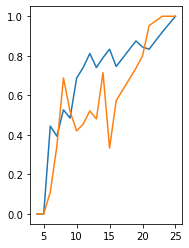

In [469]:
import seaborn

x_pre = np.array(list(precision.keys()))
y_pre = np.array(list(precision.values()))

x_rec = np.array(list(recall.keys()))
y_rec = np.array(list(recall.values()))

plt.subplot(1, 2, 2)
plt.plot(x_pre,y_pre)
plt.plot(x_rec,y_rec)

In [340]:
from PyPDF2 import PdfFileReader
from PyPDF2 import PdfFileWriter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from collections import Counter

def new_file(filename): 
    data = ""
    with open("files/" + filename, 'rb') as f:
        try:
            pdf_reader = PdfFileReader(f)
            pdf_writer = PdfFileWriter()
            for i in range(4, pdf_reader.getNumPages()):
                page = pdf_reader.getPage(i)
                page.cropBox.lowerLeft = (0, 720)
                page.cropBox.upperRight = (595, 50)
                media = page.mediaBox

                if media.getUpperRight_x() - media.getUpperLeft_x() < media.getUpperRight_y() - \
                        media.getLowerRight_y():
                    data += page.extractText()
        except Exception as e:
            print("FAILURE ON: " + filename, e)
    return data

In [341]:
def word_frequency(text, file_name, j):
    new_tokens = word_tokenize(text)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens = [t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    new_tokens = [t for t in new_tokens if len(t) > 2]
    lemmatizer = WordNetLemmatizer()
    new_tokens = [lemmatizer.lemmatize(t) for t in new_tokens]

    # counts the words, pairs and trigrams
    counted = Counter(new_tokens)
    counted_2 = Counter(ngrams(new_tokens, 2))
    counted_3 = Counter(ngrams(new_tokens, 3))

    lengths = [len(counted.items()), len(counted_2.items()), len(counted_3.items())]
    data_list = []
    for items in [counted.items(), counted_2.items(), counted_3.items()]:
        data_list += sorted(list(items), key=lambda x: x[1], reverse=True)


    # creates 3 data frames and returns them
    df = pd.DataFrame(data_list,  columns=['n-gram', 'frequency'])

    count_list = [j for i in range(len(df))]
    file_list = [file_name.replace(".pdf", "") for i in range(len(df))]

    df.insert(0, "filecount", count_list)
    df.insert(1, "filename", file_list)

    types = ["unigram", "bigram", "trigram"]

    type_list = []
    for i in range(3):
        for j in range(lengths[i]):
            type_list.append(types[i])

    df.insert(1, "type", type_list)

    return df

In [423]:
filename = "SC26-URF-IS-PLN-005063-000_000.PDF"
data = new_file(filename)
dataframe_new = word_frequency(data, filename, j)
if dataframe_new.empty:
    print("EMPTY DATAFRAME: " + filename)

In [380]:
dataframe_new

,filecount,type,filename,n-gram,frequency
0,22,unigram,SC26-SPS-PM-PRO-005091-000,subsea,76
1,22,unigram,SC26-SPS-PM-PRO-005091-000,interface,46
2,22,unigram,SC26-SPS-PM-PRO-005091-000,project,41
3,22,unigram,SC26-SPS-PM-PRO-005091-000,schlumberger,40
4,22,unigram,SC26-SPS-PM-PRO-005091-000,company,39
...,...,...,...,...,...
3398,22,trigram,SC26-SPS-PM-PRO-005091-000,"(interf, ace, form)",1
3399,22,trigram,SC26-SPS-PM-PRO-005091-000,"(ace, form, native)",1
3400,22,trigram,SC26-SPS-PM-PRO-005091-000,"(form, native, excel)",1
3401,22,trigram,SC26-SPS-PM-PRO-005091-000,"(native, excel, file)",1


In [424]:
n_grams = dataframe_new["n-gram"].tolist()
frequencies = dataframe_new["frequency"].tolist()
words_n_frequencies = [(n_grams[j], frequencies[j]) for j in range(len(n_grams))]

In [425]:
word_encoding = np.zeros(len(words_list))
for pair in words_n_frequencies:
    if pair[0] in words_list:
        word_encoding[words_list.index(pair[0])] = pair[1]

In [407]:
len([i for i in word_encoding if i != 0])

560

In [430]:
pred_x = []
pred_x.append(word_encoding.tolist())
for i in range(24):
    pred_x.append(np.ones(len(word_encoding)))
pred_y = []
for i in range(no_of_people):
    pred_y.append(models[i].predict(pred_x))

In [420]:
pred_y

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [431]:
final = []
for i in range(no_of_people):
    final.append(pred_y[i][0])

In [432]:
final

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]